**Goal** :

To develop an **AI-powered Query Routing Agent** that intelligently determines the best source for answering user queries, using a combination of **Vectorstore** (backed by Astra DB) and **Wikipedia search**.

By leveraging LangChain, Hugging Face embeddings, and Groq’s LLM, the system aims to provide accurate, context-aware, and efficient answers to a wide range of user queries.

1. Install Dependencies


In [ ]:
!pip install -U langchain_community tiktoken langchain-groq langchainhub chromadb langchain langgraph langchain_huggingface

In [ ]:
!pip install --quiet langchain_community


In [ ]:
!pip install --quiet langchain langgraph cassio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 59.0 MB/s eta 0:00:00


2.
Connection with AstraDB , using AstraDB token and database ID to connect to AstraDB.

AstraDB serves as a Vectorstore to store and retrieve embeddings.


In [ ]:
import cassio
#connection of AstraDB

astra_db_token="AstraCS:OLIAtbSIEDtatwEJCQIChrff:36e7bfa4ac1d69d9757acca7eb7a293cf11f2484e8a75e74f086a92e1c8d8a70"
astra_db_id="05a0db24-2f41-4441-a2eb-444262c86b7c"
cassio.init(token=astra_db_token,database_id=astra_db_id)

-
3.

--> Load documents from the URLs using the WebBaseLoader.

--> Split documents into smaller chunks for better embedding generation.

--> Prepare data for storage in the Vectorstore.




In [ ]:
### build index

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader

#Docs to index

# Docs to index
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
    "https://www.theglobeandmail.com/investing/markets/stocks/TSLA/pressreleases/30016867/tesla-stock-could-be-the-ultimate-artificial-intelligence-ai-play-but-there-are-2-reasons-to-avoid-it-heading-into-2025/",
    "https://www.ibm.com/think/topics/machine-learning",
    "https://www.ibm.com/think/topics/object-detection",
    "https://www.ibm.com/think/topics/langchain",
    "https://www.ibm.com/think/topics/langchain"
]



docs=[WebBaseLoader(url).load() for url in urls]
doc_list = [item for sublist in docs for item in sublist ]
print(doc_list)
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=500, chunk_overlap=0)
docs_split = texts = text_splitter.split_documents(doc_list)

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [ ]:
docs_split

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

4.


Generating embeddings using the Hugging Face model **all-MiniLM-L6-v2.**

These embeddings represent the semantic meaning of each document chunk.

These embeddings convert the text extracted from website into numerical form.

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

5.


Create a Vectorstore using Cassandra (connected to AstraDB).

Store the embeddings and their corresponding document chunks in the Vectorstore.

In [ ]:
from langchain.vectorstores.cassandra import Cassandra
astra_vector_store=Cassandra(embedding=embeddings,table_name="qa_mini_demo",session=None,keyspace=None)

In [ ]:
from langchain.indexes.vectorstore import VectorStoreIndexWrapper
astra_vector_store.add_documents(docs_split)

print("Inserted %i headline" % len(docs_split))

astra_vector_store=VectorStoreIndexWrapper(vectorstore=astra_vector_store)

Inserted 148 headline


Defining a retriever that queries the Vectorstore.

Retrieving relevant document chunks based on the query's similarity to stored embeddings.

In [ ]:
retriever=astra_vector_store.vectorstore.as_retriever()
retriever.invoke("What is agent")


[Document(id='a56bf2b66ece43c7b940b119d7f2d66b', metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context lear

6.

Define a routing mechanism (router) to decide whether a query should be sent to the Vectorstore or Wikipedia.

In [ ]:
## Langraph Application

# use to route query

from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import Field,BaseModel

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
# Data model

class RouteQuery(BaseModel):
  """route a user query to the most relevant datasource """
  datasource: Literal["vectorstore","wiki_search"] =  Field(
      ...,
      description="Given a user question choose to route it to wikipedia or a vectorstore."
  )

In [ ]:
from google.colab import userdata
import os
from langchain_groq import ChatGroq

groq_api_key = userdata.get('groq_api_key')
print(groq_api_key)

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


7.

used to initialize a Large Language Model (LLM) using Groq API.

ChatGroq connects to Groq's platform to interact with a large language model (LLM).

**llama-3.1-70b-versatile** is the name of the pre-trained model

can use it to interact with the LLaMA model.


In [ ]:
llm=ChatGroq(groq_api_key=groq_api_key,model_name="llama-3.1-70b-versatile")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x78f0f9911450>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x78f0f9910610>, model_name='llama-3.1-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [ ]:
structured_llm_router = llm.with_structured_output(RouteQuery)


8.

Defining a routing mechanism (router) to decide whether a query should be sent to the Vectorstore or Wikipedia.

In [ ]:
# Prompt
system = """You are an expert at routing a user question to a vectorstore or wikipedia.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use wiki-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router

In [ ]:
print(question_router.invoke({"question": "What is agent"}))

datasource='vectorstore'


In [ ]:
!pip install --quiet langchain_community
!pip install wikipedia

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11679 sha256=806767de96b6d3608e0d98bb23be84046e5c7ce7de308f5de998e59832f645bb
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia


9.

Using Wikipedia API as an alternative information source.

If the query is not relevant to the Vectorstore, the system retrieves information from Wikipedia.


In [ ]:

# responsible in running api queries

from langchain_community.tools.wikipedia.tool import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
api_wrapper = WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=200)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper)

In [ ]:
wiki.run("Who is Shahrukh Khan")

'Page: Shah Rukh Khan\nSummary: Shahrukh Khan (pronounced [ˈʃɑːɦɾʊx xɑːn] ; born 2 November 1965), also known by the initialism SRK, is an Indian actor and film producer who works in Hindi cinema. Refer'

10.

The state of the system is the **memory** of the system, where it keeps track of important information that helps it make decisions and process tasks.

In [ ]:
# AI agent application using Langraph

# Responsible for managing state of ai agent
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
  """

  Represents State of our Graph

  Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
  """
  question: str
  generation: str
  documents: List[str]



11.

**retrieve(state):** Retrieves relevant documents from the Vectorstore.



In [ ]:
from langchain.schema import Document

def retrieve(state):
  """
  Retrieve documents

  Args:

    state (dict): The current graph state

  Returns:
    state (dict): New key added to state, documents, that contains retrieved documents
  """
  print("---Retrieve---")
  question=state["question"]


  #Retrieval
  documents=retriever.invoke(state["question"])
  return {"documents":documents,"question":question}

12.

**wiki_search(state):** Searches Wikipedia for answers to queries not in the Vectorstore.

In [ ]:
def wiki_search(state):
  """
  Search wikipedia based on re phrased question

  Args:

    state (dict): The current graph state

  Returns:
    state (dict): updates documents key with appended web results

  """

  print("---Wikipedia---")

  question=state["question"]
  print(question)

  # Wiki Search

  docs=wiki.invoke({"query":question})

  wiki_results = docs
  wiki_results = Document(page_content=wiki_results)

  return {"documents": wiki_results,"question": question}


13.

**route_question(state):** Determines whether the query should be routed to the Vectorstore or Wikipedia.

In [ ]:
### Edges ###


# if the query asked is from the wikipedia it retruns wikipedia search otherwise it will return vector store in which we have stored our data

def route_question(state):
    """
    Route question to wiki search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "wiki_search":
        print("---ROUTE QUESTION TO Wiki SEARCH---")
        return "wiki_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

15.

Define a **workflow graph** using LangGraph:

**Start** with route_question to decide the query source.

**Route** to either retrieve or wiki_search based on the decision.

**End** the workflow after retrieving the results.


In [ ]:
# Langraph Flow

from langgraph.graph import StateGraph,END,START

workflow=StateGraph(GraphState)

#define nodes

workflow.add_node("wiki_search",wiki_search) # websearch
workflow.add_node("retrieve",retrieve) #vector search


# build graph

workflow.add_conditional_edges(
    START,
    route_question,
    {
        "wiki_search":"wiki_search",
        "vectorstore":"retrieve"
    },
)

workflow.add_edge("retrieve",END)
workflow.add_edge("wiki_search",END)

# compile

app=workflow.compile()

17.

Display workflow graph

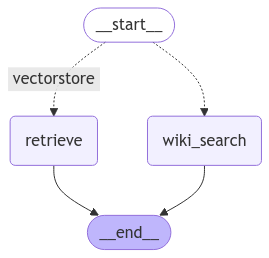

In [ ]:
# display graph
from IPython.display import Image, display

try:
  display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
  # this requires some dependencies , it is optional
  print(e)

18.

Asking from User

In [ ]:
from pprint import pprint

# Run
inputs = {
    "question": "What is an agent"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'][0].dict()['metadata']['description'])

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---Retrieve---


"Node 'retrieve':"
'\n---\n'
('Building agents with LLM (large language model) as its core controller is a '
 'cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer '
 'and BabyAGI, serve as inspiring examples. The potentiality of LLM extends '
 'beyond generating well-written copies, stories, essays and programs; it can '
 'be framed as a powerful general problem solver.\n'
 'Agent System Overview\n'
 'In a LLM-powered autonomous agent system, LLM functions as the agent’s '
 'brain, complemented by several key components:\n'
 '\n'
 'Planning\n'
 '\n'
 'Subgoal and decomposition: The agent breaks down large tasks into smaller, '
 'manageable subgoals, enabling efficient handling of complex tasks.\n'
 'Reflection and refinement: The agent can do self-criticism and '
 'self-reflection over past actions, learn from mistakes and refine them for '
 'future steps, thereby improving the quality of final results.\n'
 '\n'
 '\n'
 'Memory\n'
 '\n'
 'Short-term memory: I wo

<ipython-input-34-1293dddc5313>:16: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  pprint(value['documents'][0].dict()['metadata']['description'])


In [ ]:
from pprint import pprint

# Run
inputs = {
    "question": "Who is salman khan?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'])

---ROUTE QUESTION---
---ROUTE QUESTION TO Wiki SEARCH---
---Wikipedia---
Who is salman khan?
"Node 'wiki_search':"
'\n---\n'
Document(metadata={}, page_content='Page: Salman Khan\nSummary: Abdul Rashid Salim Salman Khan (pronounced [səlˈmɑːn xɑːn]; born 27 December 1965) is an Indian actor, film producer, and television personality who predominantly works in H')


In [ ]:
from pprint import pprint

# Run
inputs = {
    "question": "What is object detection"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'])

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---Retrieve---


"Node 'retrieve':"
'\n---\n'
[Document(id='562c1d06da504dc6b3898d69db359cd7', metadata={'description': 'Object detection is a technique that uses neural networks to localize and classifying objects in images.', 'language': 'en', 'source': 'https://www.ibm.com/think/topics/object-detection', 'title': 'What is Object Detection? | IBM'}, page_content='What is Object Detection? | IBM\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n                        \n\n\n\n  \n    What is object detection?\n\n\n\n\n\n\n    \n\n\n                    \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n                            Artificial Intelligence\n                        \n\n\n\n\n\n                    \n\n\n\n  \n    3 January 2024\n\n\n\n\n\n\n    \n\n\n                \n\n\n\n\n\n\n\n\n\n\n\n\n                Link copied\n            \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n     